In [1]:
import sys
import os
import gc
import lightgbm as lgb
import pandas as pd

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

from database.dataset.new_data import DataBuilder
from database.connection import sql_connection
from pathlib import Path
from skopt.space import Real, Integer
from modules.interface import RunModel, RunOptimization
from plots import plots

In [2]:
# Extrair dados do terceiro arquivo SQLite

# Base robusta: script OU notebook
try:
    BASE_DIR = Path(__file__).resolve().parent
except NameError:
    # Jupyter / IPython
    BASE_DIR = Path.cwd()

# Voltar um diretório e entrar em database/data/lorenzetti
LORENZETTI_DIR = (BASE_DIR / '..' / 'database' / 'data' / 'lorenzetti').resolve()

qrings_dataframe = pd.concat(
    [
        sql_connection.extrair_dados_sqlite(LORENZETTI_DIR / 'StdRings.db', 'events'),
        sql_connection.extrair_dados_sqlite(LORENZETTI_DIR / 'QRings.db', 'events'),
        sql_connection.extrair_dados_sqlite(LORENZETTI_DIR / 'ClusterData.db', 'events')
    ],
    axis=1
)

gc.collect()

std_dataframe = pd.concat(
    [
        sql_connection.extrair_dados_sqlite(LORENZETTI_DIR / 'StdRings.db', 'events'),
        sql_connection.extrair_dados_sqlite(LORENZETTI_DIR / 'ClusterData.db', 'events')
    ],
    axis=1
)

gc.collect()

0

In [3]:
# Definição dos bins de entrada
bins_et = {'cluster_et':[5000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 150000, 200000, 250000, 900000, 3000000]}
bins_eta = {'cluster_eta':[0, 0.6, 0.8, 1.2, 1.37, 1.52, 1.8, 2.0, 2.2, 2.5]}
# # Lista para armazenar o resultado final
# params = []
params=[[{'cluster_eta':[0.6, 0.8]}, {'cluster_et':[20000,30000]}]]

qrings_data=DataBuilder(
    dataframe=qrings_dataframe,
    bins_et=bins_et,
    bins_eta=bins_eta
    ).run(
    topology='quarter_rings', 
    train_size=0.7, 
    random_state=1, 
    model='default', 
    bins_size=None
    )

std_data=DataBuilder(
    dataframe=std_dataframe,
    bins_et=bins_et,
    bins_eta=bins_eta
    ).run(
    topology='raw', 
    train_size=0.7, 
    random_state=1, 
    model='default', 
    bins_size=None
    )

[quarter_rings] Executando Quarter Rings (default)...
(66677, 974)
[raw] Executando lógica Raw Default...
new_processing_print ['StdRings_0', 'StdRings_1', 'StdRings_2', 'StdRings_3', 'StdRings_4', 'StdRings_5', 'StdRings_6', 'StdRings_7', 'StdRings_8', 'StdRings_9', 'StdRings_10', 'StdRings_11', 'StdRings_12', 'StdRings_13', 'StdRings_14', 'StdRings_15', 'StdRings_16', 'StdRings_17', 'StdRings_18', 'StdRings_19', 'StdRings_20', 'StdRings_21', 'StdRings_22', 'StdRings_23', 'StdRings_24', 'StdRings_25', 'StdRings_26', 'StdRings_27', 'StdRings_28', 'StdRings_29', 'StdRings_30', 'StdRings_31', 'StdRings_32', 'StdRings_33', 'StdRings_34', 'StdRings_35', 'StdRings_36', 'StdRings_37', 'StdRings_38', 'StdRings_39', 'StdRings_40', 'StdRings_41', 'StdRings_42', 'StdRings_43', 'StdRings_44', 'StdRings_45', 'StdRings_46', 'StdRings_47', 'StdRings_48', 'StdRings_49', 'StdRings_50', 'StdRings_51', 'StdRings_52', 'StdRings_53', 'StdRings_54', 'StdRings_55', 'StdRings_56', 'StdRings_57', 'StdRings_58

In [5]:
space_lgbm = [
    Real(name='learning_rate', low = 0.01 , high = 0.9),
    Integer(name='num_leaves', low = 200, high = 1000),
    Integer(name='max_depth', low = 200, high = 1000),
    Real(name='feature_fraction', low = 0.1 , high = 1),
    Real(name='bagging_fraction', low = 0.1 , high = 1),
    Integer(name='bagging_freq', low = 1, high = 10),
    Real(name='lambda_l1',low = 0.0, high = 1),
    Real(name='lambda_l2',low = 0.0, high = 1)
]

space_xgboost = [
    Real(name='learning_rate', low=0.01, high=0.9),
    Integer(name='max_depth', low=3, high=15),
    Real(name='colsample_bytree', low=0.1, high=1.0),
    Real(name='subsample', low=0.1, high=1.0),
    Real(name='alpha', low=0.0, high=1.0),
    Real(name='lambda', low=0.0, high=1.0),
    Integer(name='min_child_weight', low=1, high=10)
]

fixed_params_lgbm = {
    "boosting_type": "gbdt",
    'objective': 'mae', 
    'metric': 'mae', 
    'num_iterations ': 200,
    'random_state': 1, 
    'n_jobs': -1, 
    'verbose': -1
}


fixed_params_xgboost ={
       'learning_rate': 0.1,
       'max_depth': 4,
       'objective': 'reg:squarederror',
       'eval_metric': 'mae',
       'lambda_l1' : 2,
       'lambda_l2': 3,
       'random_state': 1,
       'tree_method': 'hist',
       'device': 'cuda'

}

calibration_kwargs = {'callbacks':[lgb.early_stopping(stopping_rounds=5, verbose=False)]}
calibration_kwargs_xgboost = {
    'early_stopping_rounds': 5,
    'verbose_eval': False
}
optimization_kwargs = {'n_initial_points': 10,
                        'n_calls': 25,
                        'initial_point_generator': 'lhs',
                        'random_state': 1,
                       }

qrings_optimizer_lgbm = RunOptimization()
r1=qrings_optimizer_lgbm.run(opt_class='gp_minimize',
    model_class="lgbm",
    datasets=qrings_data,
    space=space_lgbm, 
    fixed_params=fixed_params_lgbm,
    metric='mae',
    calibration_kwargs=calibration_kwargs,
    optimization_kwargs= optimization_kwargs
)

std_optimizer_lgbm = RunOptimization()
r2=std_optimizer_lgbm.run(opt_class='gp_minimize',
    model_class="lgbm",
    datasets=std_data,
    space=space_lgbm, 
    fixed_params=fixed_params_lgbm,
    metric='mae',
    calibration_kwargs=calibration_kwargs,
    optimization_kwargs= optimization_kwargs
)

qrings_optimizer_xgboost = RunOptimization()
r3 = qrings_optimizer_xgboost.run(
    opt_class='gp_minimize',
    model_class="xgboost",
    datasets=qrings_data,
    space=space_xgboost, 
    fixed_params=fixed_params_xgboost,
    metric='mae',
    calibration_kwargs=calibration_kwargs_xgboost,
    optimization_kwargs= optimization_kwargs
    )

std_optimizer_xgboost = RunOptimization()
r4 = std_optimizer_xgboost.run(
    opt_class='gp_minimize',
    model_class="xgboost",
    datasets=std_data,
    space=space_xgboost, 
    fixed_params=fixed_params_xgboost,
    metric='mae',
    calibration_kwargs=calibration_kwargs_xgboost,
    optimization_kwargs= optimization_kwargs
)

/home/akim/Documents/projetos/ic/calibration_main/calibration_refactor/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [14:31:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "lambda_l1", "lambda_l2" } are not used.

  self.starting_round = model.num_boosted_rounds()
/home/akim/Documents/projetos/ic/calibration_main/calibration_refactor/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [14:31:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "lambda_l1", "lambda_l2" } are not used.

  self.starting_round = model.num_boosted_rounds()
/home/akim/Documents/projetos/ic/calibration_main/calibration_refactor/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [14:31:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "lambda_l1", "lambda_l2" } are not used.

  self.starting_round = model.num_boosted_rounds()
/home/akim/Documents/projetos/ic/calibration_main/calibration_refactor/.venv/lib/python3.12

# PLOT

/home/akim/Documents/projetos/ic/calibration_main/calibration_refactor/.venv/lib/python3.12/site-packages/matplotlib/axes/_axes.py:3831: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err


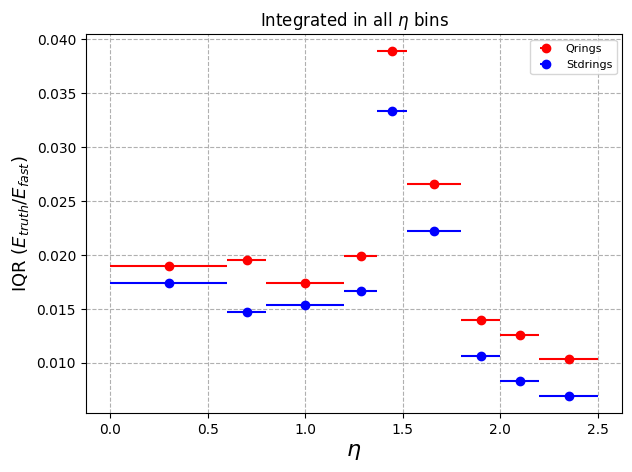

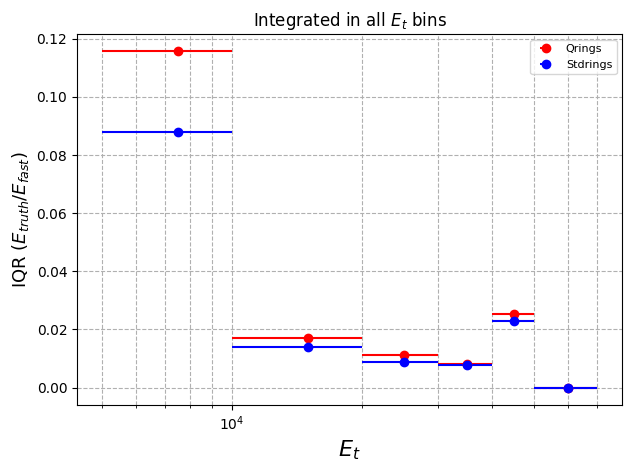

/home/akim/Documents/projetos/ic/calibration_main/calibration_refactor/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [14:36:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "lambda_l1", "lambda_l2" } are not used.

  self.starting_round = model.num_boosted_rounds()
/home/akim/Documents/projetos/ic/calibration_main/calibration_refactor/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [14:36:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "lambda_l1", "lambda_l2" } are not used.

  self.starting_round = model.num_boosted_rounds()
/home/akim/Documents/projetos/ic/calibration_main/calibration_refactor/.venv/lib/python3.12/site-packages/matplotlib/axes/_axes.py:3831: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err


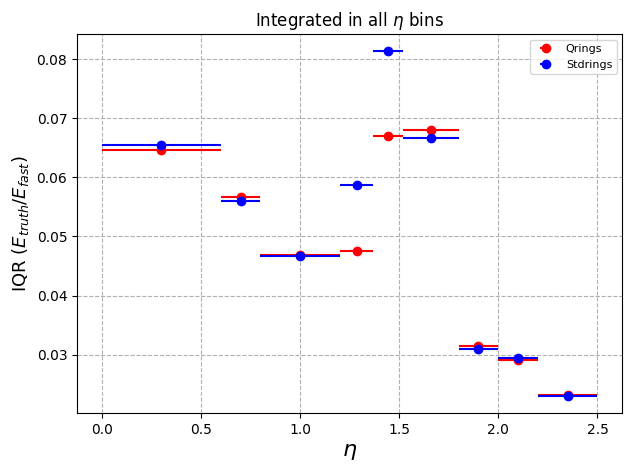

In [6]:
config=[{'label':'Qrings',
         'fmt':'o',
         'color':'r'},
         {'label':'Stdrings',
         'fmt':'o',
         'color':'b'}
         ]

plot_eta=plots.PlotConfig([qrings_optimizer_lgbm.optimizer, std_optimizer_lgbm.optimizer], qrings_dataframe, bins_eta)
plot_eta.plot_errorbars(plot_eta._set_plot(), config, 
                        title=r'Integrated in all $\eta$ bins',
                        y_label=r'IQR ($E_{truth}/E_{fast}$)',
                        x_label=r'$\eta$',
                        )

plot_et=plots.PlotConfig([qrings_optimizer_lgbm.optimizer, std_optimizer_lgbm.optimizer], qrings_dataframe, bins_et)
plot_et.plot_errorbars(plot_et._set_plot(), config,
                        title=r'Integrated in all $E_t$ bins',
                        y_label=r'IQR ($E_{truth}/E_{fast}$)',
                        x_label=r'$E_t$',
                        xscale='log'
                        )

plot_eta=plots.PlotConfig([qrings_optimizer_xgboost.optimizer, std_optimizer_xgboost.optimizer], qrings_dataframe, bins_eta)
plot_eta.plot_errorbars(plot_eta._set_plot(), config, 
                        title=r'Integrated in all $\eta$ bins',
                        y_label=r'IQR ($E_{truth}/E_{fast}$)',
                        x_label=r'$\eta$',
                        )
